# FINAL

In [1]:
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt 
import matplotlib as mplt
import matplotlib.lines as mlines
import scipy.optimize as opt
import pickle

In [2]:
## Original Parameters
samples=50000; T=10; K=1; 
r=0.01; mu=0.02; sig=0.1; Y1_0=1; 
c=0.075; xi=0.000597; lam0=0.0087; lx=1000
t=np.array(range(0,T+1))

In [3]:
## functions
### simulate risky asset
def getY1(samples,T,r,mu,sig,Y1_0):
    # simulation of Y1
    def get_dW(T,N, seed: Optional[int] = None):
        np.random.seed(seed)
        return [np.random.normal(loc=0, scale=1,size=T) for _ in range(N)]
    dW1= get_dW(T,samples)
    dW1=dW1[:]
    W1=[[0 for _ in range(T+1)] for _ in range(samples)]
    Y1=[[Y1_0 for _ in range(samples)] for _ in range(T+1)]
    for n in range(samples):
        for s in range(T):
            W1[n][(s+1)]=W1[n][s]+dW1[n][s]
            Y1[(s+1)][n]=Y1[0][n]*np.exp((mu-(sig**2)/2)*(s+1)+sig*W1[n][(s+1)])
    return Y1

### simulate mortality process
def getN(samples,T,c,xi,lam0,lx):
    # generalized OU process simulation
    def survival(t,N):
        # dlamda=c lambda dt+xi dWt
        # mortality parameters
        # int_0^t lambda ds is normally distributed with mean and variance
        mean=lam0 * (np.exp(c*t)-1)/c
        variance=(xi/c)**2*(c/2*((np.exp(c*t)-1)/c)**2-(np.exp(c*t)-1)/c+t)
        return np.random.normal(mean, variance, N)

    S0=1 #prob of surviving till 0 given you're alive at zero is 1
    S=[np.exp(-survival(s,samples)) for s in range(T+1)]
    q=[[1-S[i+1][j]/S[i][j] for j in range(samples)] for i in range(T)]

    N=[[lx for _ in range(samples)] for _ in range(T+1)]
    for n in range(samples-1):
        for s in range(T):
            if q[s][n]>1:
                print(q[s][n])
                q[s][n]=1
            elif q[s][n]<0:
                print(q[s][n])
                q[s][n]=0
            N[s+1][n]=N[s][n]-np.random.binomial(N[s][n], q[s][n], 1)
            N[s+1][n]=N[s+1][n].tolist()[0]
    return N

### valuation for GMAB
def getrho_MC_TC_act_GMAB(N,K,Y0,Y1,EY1,VarY1,par_a, prod: Optional[str] = "GMAB", returns: Optional[str] = 'rho', predictor: Optional[int] = 2):
    t=range(len(N))
    T=len(N)-1
    samples=len(N[0])
    NY1=[[N[s][n]*Y1[s][n] for n in range(samples)] for s in t]
    rho=[0 for s in t]
    if prod=='GMAB':
        x_=np.array(NY1)
        if type(K[0])!=list:
            GMAB=[[N[s][n]*max(Y1[s][n],K[s]) for n in range(samples)] for s in t]
        else:
            GMAB=[[N[s][n]*max(Y1[s][n],K[s][n]) for n in range(samples)] for s in t]
        rho[T]=GMAB[T]
    elif prod=='GMDB':
        GD=[[max(Y1[s][n],K[s])*Y0[T]/Y0[s] for n in range(samples)] for s in t]
        D=[[0 for n in range(samples)] for s in t]
        D[1:T+1]=[np.array(N[s])-np.array(N[s+1]) for s in range(T)]
        x_=np.array([[(N[s][n])*Y1[s][n] for n in range(samples)] for s in t])
        GMDB=[sum([D[s][n]*GD[s][n] for s in t]) for n in range(samples)]
        rho[T]=GMDB
    else:
        print('Select a Valid Product ("GMAB" or "GMDB")')
        return 'N/A'
    E_rhoS_act=[0 for s in range(T)]
    E_rhoSY1_act=[0 for s in range(T)]
    theta1_act=[0 for s in range(T)]
    theta0_act=[0 for s in range(T)]
    alpha_act=[1 for _ in range(T)]
    beta_act=[1 for _ in range(T)]
    gamma=[1 for _ in range(T)]
    pi=[0 for s in range(T)]
    toprint=[0 for _ in range(T)]
    y=[0 for _ in range(T)]
    variance=[0 for _ in range(T)]
    
    for s in range(T-1,-1,-1):
        x=x_[s]
        A= np.vstack([np.ones(len(x)),x,x**2]).T
        lsqlinear=opt.lsq_linear(A,np.array(rho[s+1]))
        #print(np.average(lsqlinear.fun))
        alpha_act[s]=lsqlinear.x
        E_rhoS_act[s]=[sum([alpha_act[s][0],alpha_act[s][1]*NY1[s][n],alpha_act[s][2]*(NY1[s][n])**2]) for n in range(samples)]
        x2=x_[s]*Y1[s]
        B= np.vstack([np.ones(len(x2)),x2,x2**2]).T
        beta_act[s]=opt.lsq_linear(B,np.array(rho[s+1])*np.array(Y1[s+1])).x
        E_rhoSY1_act[s]=beta_act[s][0]+x2*beta_act[s][1]+x2**2*beta_act[s][2]
        theta1_act[s] = (E_rhoSY1_act[s]-np.array(E_rhoS_act[s])*np.array(EY1[s]))/VarY1[s]
        theta0_act[s] = [(E_rhoS_act[s][n] - theta1_act[s][n]*EY1[s][n])/Y0[s+1] for n in range(samples)]
        if par_a != 0:
            y[s]=[(rho[s+1][i]-theta0_act[s][i]*Y0[s+1]-theta1_act[s][i]*Y1[s+1][i])**2 for i in range(samples)]
            if predictor==2:
                x3=x**2
            elif predictor==1:
                x3=x2
            elif predictor==0:
                x3=x
            else: 
                print('select a valid predictor (1 or 2)')
                return 'N/A'
            A = np.vstack([np.ones(len(x3)),x3,x3**2]).T
            gamma[s]= opt.lsq_linear(A,y[s]).x
            variance[s]=np.abs(gamma[s][0]+gamma[s][1]*x3+gamma[s][2]*x3**2)
            toprint[s]=np.average(y[s]-variance[s])
            pi[s]=np.exp(-r)*par_a*np.sqrt(np.array(variance[s]))  # result seems to be more in line with those of barigou when leaving out parameter a=0.15 here
        rho[s]=np.array(theta0_act[s])*Y0[s]+np.array(theta1_act[s])*np.array(Y1[s])+np.array(pi[s])
    if returns=='var':
        return y,variance
    else:
        return rho
    
def varyingsimulationsize(paths):
    Y1=getY1(paths,T,r,mu,sig,Y1_0)
    N=getN(paths,T,c,xi,lam0,lx)
    EY1 = [[Y1[s][n]*np.exp(mu+sig**2/2) for n in range(paths)] for s in range(T)] # Barigou19 (29)
    VarY1 = [[(Y1[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(paths)] for s in t] # Barigou19 (30)
    rho_MC_TC_GMAB_=getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0)
    rho_MC_TC_act_GMAB_=getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0.15)
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_

def varyingT(T_adj):
    Y0_T=[np.exp(-r*(T_adj-x)) for x in range(T_adj+1)]
    Y1_T=getY1(samples,T_adj,r,mu,sig,Y1_0)
    N_T=getN(samples,T_adj,c,xi,lam0,lx)
    EY1_T = [[Y1_T[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T_adj)] # Barigou19 (29)
    VarY1_T = [[(Y1_T[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T_adj+1)] # Barigou19 (30)
    rho_MC_TC_GMAB_T = getrho_MC_TC_act_GMAB(N_T,Y0_T,Y0_T,Y1_T,EY1_T,VarY1_T,0,"GMAB")
    rho_MC_TC_act_GMAB_T= getrho_MC_TC_act_GMAB(N_T,Y0_T,Y0_T,Y1_T,EY1_T,VarY1_T,0.15,"GMAB")
    rho_MC_TC_GMDB_T = getrho_MC_TC_act_GMAB(N_T,Y0_T,Y0_T,Y1_T,EY1_T,VarY1_T,0,"GMDB")
    rho_MC_TC_act_GMDB_T= getrho_MC_TC_act_GMAB(N_T,Y0_T,Y0_T,Y1_T,EY1_T,VarY1_T,0.15,"GMDB")
    return rho_MC_TC_GMAB_T, rho_MC_TC_act_GMAB_T, rho_MC_TC_GMDB_T, rho_MC_TC_act_GMDB_T

### varying parameters
def varyingK(K_adj):
    EY1 = [[Y1[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)]
    VarY1 = [[(Y1[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T+1)]
    rho_MC_TC_GMAB_K = getrho_MC_TC_act_GMAB(N,K_adj,Y0,Y1,EY1,VarY1,0,"GMAB")
    rho_MC_TC_act_GMAB_K= getrho_MC_TC_act_GMAB(N,K_adj,Y0,Y1,EY1,VarY1,0.15,"GMAB")
    return rho_MC_TC_GMAB_K, rho_MC_TC_act_GMAB_K
def varyingr(r_adj):
    Y0_r=[np.exp(-r_adj*(T-x)) for x in range(T+1)]
    Y1_r=getY1(samples,T,r_adj,mu,sig,Y1_0)
    EY1_r = [[Y1_r[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)]
    VarY1_r = [[(Y1_r[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T+1)]
    rho_MC_TC_GMAB_r = getrho_MC_TC_act_GMAB(N,Y0_r,Y0_r,Y1_r,EY1_r,VarY1_r,0,"GMAB")
    rho_MC_TC_act_GMAB_r= getrho_MC_TC_act_GMAB(N,Y0_r,Y0_r,Y1_r,EY1_r,VarY1_r,0.15,"GMAB")
    rho_MC_TC_GMDB_r = getrho_MC_TC_act_GMAB(N,Y0_r,Y0_r,Y1_r,EY1_r,VarY1_r,0,"GMDB")
    rho_MC_TC_act_GMDB_r= getrho_MC_TC_act_GMAB(N,Y0_r,Y0_r,Y1_r,EY1_r,VarY1_r,0.15,"GMDB")
    return rho_MC_TC_GMAB_r, rho_MC_TC_act_GMAB_r,  rho_MC_TC_GMDB_r, rho_MC_TC_act_GMDB_r, 
def varyingmu(mu):
    Y0_=[np.exp(-r*(T-x)) for x in range(T+1)]
    Y1_=getY1(samples,T,r,mu,sig,Y1_0)
    EY1_ = [[Y1_[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)]
    VarY1_ = [[(Y1_[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T+1)]
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_
def varyingsig(sig):
    Y0_=[np.exp(-r*(T-x)) for x in range(T+1)]
    Y1_=getY1(samples,T,r,mu,sig,Y1_0)
    EY1_ = [[Y1_[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)]
    VarY1_ = [[(Y1_[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T+1)]
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_
def varyinginitial(Y1_0):
    Y0_=[np.exp(-r*(T-x)) for x in range(T+1)]
    Y1_=getY1(samples,T,r,mu,sig,Y1_0)
    EY1_ = [[Y1_[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)]
    VarY1_ = [[(Y1_[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in range(T+1)]
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N,Y0_,Y0_,Y1_,EY1_,VarY1_,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_
def varyingmortc(c):
    N_=getN(samples,T,c,xi,lam0,lx)
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_

def varyingmortxi(xi):
    N_=getN(samples,T,c,xi,lam0,lx)
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_

def varyingmort_lam0(lam0):
    N_=getN(samples,T,c,xi,lam0,lx)
    rho_MC_TC_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMAB")
    rho_MC_TC_act_GMAB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMAB")
    rho_MC_TC_GMDB_ = getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMDB")
    rho_MC_TC_act_GMDB_= getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMDB")
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_

def varyingportsize(lx):
    N_=getN(samples,T,c,xi,lam0,lx)
    rho_MC_TC_GMAB_= np.array(getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMAB"))/lx
    rho_MC_TC_act_GMAB_= np.array(getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMAB"))/lx
    rho_MC_TC_GMDB_ = np.array(getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0,"GMDB"))/lx
    rho_MC_TC_act_GMDB_= np.array(getrho_MC_TC_act_GMAB(N_,Y0,Y0,Y1,EY1,VarY1,0.15,"GMDB"))/lx
    return rho_MC_TC_GMAB_, rho_MC_TC_act_GMAB_, rho_MC_TC_GMDB_,rho_MC_TC_act_GMDB_

## Simulation

### Riskless and Risky Asset and the Mortality Process
Y0=[np.exp(-r*(T-x)) for x in t]
Y1=getY1(samples,T,r,mu,sig,Y1_0)
N=getN(samples,T,c,xi,lam0,lx)

EY1 = [[Y1[s][n]*np.exp(mu+sig**2/2) for n in range(samples)] for s in range(T)] # Barigou19 (29)
VarY1 = [[(Y1[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(samples)] for s in t] # Barigou19 (30)

### Barigou's OG
rho_MC_TC_GMAB = getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0,"GMAB")
rho_MC_TC_act_GMAB = getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0.15,"GMAB")
rho_MC_TC_GMDB = getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0,"GMDB")
rho_MC_TC_act_GMDB = getrho_MC_TC_act_GMAB(N,Y0,Y0,Y1,EY1,VarY1,0.15,"GMDB")

### Chen's parameters
Y0_chen=[np.exp(-0.02*(T-x)) for x in range(T+1)]
Y1_chen=getY1(samples,T,0.02,0.07,0.3,Y1_0)
EY1_chen = [[Y1_chen[s][n]*np.exp(0.07+0.3**2/2) for n in range(samples)] for s in range(T)]
VarY1_chen = [[(Y1_chen[s][n])**2*np.exp(2*0.07+0.3**2)*(np.exp(0.3**2)-1) for n in range(samples)] for s in t]
Chen_MC_TC_GMAB= getrho_MC_TC_act_GMAB(N,Y0_chen,Y0_chen,Y1_chen,EY1_chen,VarY1_chen,0,"GMAB")
Chen_MC_TC_act_GMAB= getrho_MC_TC_act_GMAB(N,Y0_chen,Y0_chen,Y1_chen,EY1_chen,VarY1_chen,0.15,"GMAB")

Y0_chen_2=[np.exp(-0.02*(T-x)) for x in range(T+1)]
Y1_chen_2=getY1(samples,T,0.02,0.07,0.3,Y1_0)
EY1_chen_2 = [[Y1_chen_2[s][n]*np.exp(0.07+0.3**2/2) for n in range(samples)] for s in range(T)]
VarY1_chen_2 = [[(Y1_chen_2[s][n])**2*np.exp(2*0.07+0.3**2)*(np.exp(0.3**2)-1) for n in range(samples)] for s in t]
Chen_MC_TC_GMAB_2= getrho_MC_TC_act_GMAB(N,Y0_chen_2,Y0_chen_2,Y1_chen_2,EY1_chen_2,VarY1_chen_2,0,"GMAB")
Chen_MC_TC_act_GMAB_2= getrho_MC_TC_act_GMAB(N,Y0_chen_2,Y0_chen_2,Y1_chen_2,EY1_chen_2,VarY1_chen_2,0.15,"GMAB")

### smaller samplesize
rho_MC_TC_GMAB_5000, rho_MC_TC_act_GMAB_5000=varyingsimulationsize(5000)
rho_MC_TC_GMAB_5000_2, rho_MC_TC_act_GMAB_5000_2=varyingsimulationsize(5000)

### Predictor
partN = [[N[s][n] for n in range(50000) ] for s in t]
partY1= [[Y1[s][n] for n in range(50000) ] for s in t]
partEY1 = [[partY1[s][n]*np.exp(mu+sig**2/2) for n in range(50000)] for s in range(T)] # Barigou19 (29)
partVarY1 = [[(partY1[s][n])**2*np.exp(2*mu+sig**2)*(np.exp(sig**2)-1) for n in range(50000)] for s in t] # Barigou19 (30)


yx,variancex = getrho_MC_TC_act_GMAB(partN,Y0,Y0,partY1,partEY1,partVarY1,0.15,"GMAB",'var',0)
yx2,variancex2 = getrho_MC_TC_act_GMAB(partN,Y0,Y0,partY1,partEY1,partVarY1,0.15,"GMAB",'var',1)
yx3,variancex3= getrho_MC_TC_act_GMAB(partN,Y0,Y0,partY1,partEY1,partVarY1,0.15,"GMAB",'var',2)

### Maturity
rho_MC_TC_GMAB_T5, rho_MC_TC_act_GMAB_T5, rho_MC_TC_GMDB_T5, rho_MC_TC_act_GMDB_T5 = varyingT(5)
rho_MC_TC_GMAB_T9, rho_MC_TC_act_GMAB_T9, rho_MC_TC_GMDB_T9, rho_MC_TC_act_GMDB_T9 = varyingT(9)
rho_MC_TC_GMAB_T11, rho_MC_TC_act_GMAB_T11, rho_MC_TC_GMDB_T11, rho_MC_TC_act_GMDB_T11 = varyingT(11)
rho_MC_TC_GMAB_T20, rho_MC_TC_act_GMAB_T20, rho_MC_TC_GMDB_T20, rho_MC_TC_act_GMDB_T20 = varyingT(20)

### Guaranteed Benefit

eta=0.8
G=[[0 for _ in range(samples)] for s in t]
G[T]=[max(np.exp(r*T),eta*max([Y1[s][n] for s in range(T)])) for n in range(samples)]
rho_MC_TC_GMAB_Kexp, rho_MC_TC_act_GMAB_Kexp = varyingK(np.exp(r*np.array(t)))
rho_MC_TC_GMAB_KG, rho_MC_TC_act_GMAB_KG = varyingK(G)

### Financial Market


#### r
rho_MC_TC_GMAB_rneg, rho_MC_TC_act_GMAB_rneg, rho_MC_TC_GMDB_rneg,rho_MC_TC_act_GMDB_rneg = varyingr(-0.01)
rho_MC_TC_GMAB_rzero, rho_MC_TC_act_GMAB_rzero, rho_MC_TC_GMDB_rzero,rho_MC_TC_act_GMDB_rzero = varyingr(0)
rho_MC_TC_GMAB_r02, rho_MC_TC_act_GMAB_r02, rho_MC_TC_GMDB_r02,rho_MC_TC_act_GMDB_r02 = varyingr(0.02)

#### mu
rho_MC_TC_GMAB_muneg, rho_MC_TC_act_GMAB_muneg, rho_MC_TC_GMDB_muneg,rho_MC_TC_act_GMDB_muneg=varyingmu(-0.02)
rho_MC_TC_GMAB_mu07, rho_MC_TC_act_GMAB_mu07, rho_MC_TC_GMDB_mu07,rho_MC_TC_act_GMDB_mu07=varyingmu(0.07)

#### sigma
rho_MC_TC_GMAB_sig05, rho_MC_TC_act_GMAB_sig05, rho_MC_TC_GMDB_sig05,rho_MC_TC_act_GMDB_sig05=varyingsig(0.05)
rho_MC_TC_GMAB_sig3, rho_MC_TC_act_GMAB_sig3, rho_MC_TC_GMDB_sig3,rho_MC_TC_act_GMDB_sig3=varyingsig(0.3)

#### Y1(0)
rho_MC_TC_GMAB_Y1_0_05, rho_MC_TC_act_GMAB_Y1_0_05, rho_MC_TC_GMDB_Y1_0_05,rho_MC_TC_act_GMDB_Y1_0_05=varyinginitial(0.5)
rho_MC_TC_GMAB_Y1_0_2, rho_MC_TC_act_GMAB_Y1_0_2, rho_MC_TC_GMDB_Y1_0_2,rho_MC_TC_act_GMDB_Y1_0_2=varyinginitial(2)

### Mortality Process
#### c
rho_MC_TC_GMAB_c0075, rho_MC_TC_act_GMAB_c0075, rho_MC_TC_GMDB_c0075,rho_MC_TC_act_GMDB_c0075=varyingmortc(0.0075)
rho_MC_TC_GMAB_c015, rho_MC_TC_act_GMAB_c015, rho_MC_TC_GMDB_c015,rho_MC_TC_act_GMDB_c015=varyingmortc(0.15)

#### xi
rho_MC_TC_GMAB_xi_small, rho_MC_TC_act_GMAB_xi_small, rho_MC_TC_GMDB_xi_small, rho_MC_TC_act_GMDB_xi_small = varyingmortxi(0)
rho_MC_TC_GMAB_xi_large, rho_MC_TC_act_GMAB_xi_large, rho_MC_TC_GMDB_xi_large,rho_MC_TC_act_GMDB_xi_large= varyingmortxi(0.01)

#### lam0
rho_MC_TC_GMAB_lam0_00087, rho_MC_TC_act_GMAB_lam0_00087, rho_MC_TC_GMDB_lam0_00087,rho_MC_TC_act_GMDB_lam0_00087=varyingmort_lam0(0.00087)
rho_MC_TC_GMAB_lam0_087, rho_MC_TC_act_GMAB_lam0_087, rho_MC_TC_GMDB_lam0_087,rho_MC_TC_act_GMDB_lam0_087=varyingmort_lam0(0.087)

#### portfolio size
rho_MC_TC_GMAB_lx10, rho_MC_TC_act_GMAB_lx10, rho_MC_TC_GMDB_lx10,rho_MC_TC_act_GMDB_lx10=varyingportsize(10)
rho_MC_TC_GMAB_lx50, rho_MC_TC_act_GMAB_lx50, rho_MC_TC_GMDB_lx50,rho_MC_TC_act_GMDB_lx50=varyingportsize(50)
rho_MC_TC_GMAB_lx100, rho_MC_TC_act_GMAB_lx100, rho_MC_TC_GMDB_lx100,rho_MC_TC_act_GMDB_lx100=varyingportsize(100)
rho_MC_TC_GMAB_lx500, rho_MC_TC_act_GMAB_lx500, rho_MC_TC_GMDB_lx500,rho_MC_TC_act_GMDB_lx500=varyingportsize(500)
rho_MC_TC_GMAB_lx1000, rho_MC_TC_act_GMAB_lx1000, rho_MC_TC_GMDB_lx1000,rho_MC_TC_act_GMDB_lx1000=varyingportsize(1000)
rho_MC_TC_GMAB_lx5000, rho_MC_TC_act_GMAB_lx5000, rho_MC_TC_GMDB_lx5000,rho_MC_TC_act_GMDB_lx5000=varyingportsize(5000)



# Dump Data

### Riskless and Risky Asset and the Mortality Process
pickle.dump(Y0,open('DATA/Y0OG.p','wb'))
pickle.dump(Y1,open('DATA/Y1OG.p', 'wb'))
pickle.dump(N, open('DATA/mortOG.p', 'wb'))

pickle.dump(EY1, open('DATA/EY1OG.p', 'wb'))
pickle.dump(VarY1, open('DATA/VarY1OG.p', 'wb'))

### Barigou's OG
pickle.dump(rho_MC_TC_GMAB, open('DATA/rho_MC_TC_GMAB.p', 'wb'))
pickle.dump(rho_MC_TC_act_GMAB, open('DATA/rho_MC_TC_act_GMAB.p', 'wb'))
pickle.dump(rho_MC_TC_GMDB, open('DATA/rho_MC_TC_GMDB.p', 'wb'))
pickle.dump(rho_MC_TC_act_GMDB, open('DATA/rho_MC_TC_act_GMDB.p', 'wb'))

### Chen's parameters
pickle.dump(Chen_MC_TC_GMAB, open('DATA/Chen_MC_TC_GMAB.p', 'wb'))
pickle.dump(Chen_MC_TC_GMAB_2, open('DATA/Chen_MC_TC_GMAB_2.p', 'wb'))
pickle.dump(Chen_MC_TC_act_GMAB, open('DATA/Chen_MC_TC_act_GMAB.p', 'wb'))
pickle.dump(Chen_MC_TC_act_GMAB_2, open('DATA/Chen_MC_TC_act_GMAB_2.p', 'wb'))

### smaller samplesize
pickle.dump(rho_MC_TC_GMAB_5000,open('DATA/rho_MC_TC_GMAB_5000.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_5000,open('DATA/rho_MC_TC_act_GMAB_5000.p','wb'))
pickle.dump(rho_MC_TC_GMAB_5000_2,open('DATA/rho_MC_TC_GMAB_5000_2.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_5000_2,open('DATA/rho_MC_TC_act_GMAB_5000_2.p','wb'))

### Predictor
pickle.dump(yx,open('DATA/yx.p','wb'))
pickle.dump(variancex,open('DATA/variancex.p','wb'))
pickle.dump(variancex2,open('DATA/variancex2.p','wb'))
pickle.dump(variancex3,open('DATA/variancex3.p','wb'))

### Maturity
pickle.dump(rho_MC_TC_GMAB_T5,open('DATA/rho_MC_TC_GMAB_T5.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_T5,open('DATA/rho_MC_TC_act_GMAB_T5.p','wb'))
pickle.dump(rho_MC_TC_GMDB_T5,open('DATA/rho_MC_TC_GMDB_T5.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_T5,open('DATA/rho_MC_TC_act_GMDB_T5.p','wb'))

pickle.dump(rho_MC_TC_GMAB_T9,open('DATA/rho_MC_TC_GMAB_T9.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_T9,open('DATA/rho_MC_TC_act_GMAB_T9.p','wb'))
pickle.dump(rho_MC_TC_GMDB_T9,open('DATA/rho_MC_TC_GMDB_T9.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_T9,open('DATA/rho_MC_TC_act_GMDB_T9.p','wb'))

pickle.dump(rho_MC_TC_GMAB_T11,open('DATA/rho_MC_TC_GMAB_T11.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_T11,open('DATA/rho_MC_TC_act_GMAB_T11.p','wb'))
pickle.dump(rho_MC_TC_GMDB_T11,open('DATA/rho_MC_TC_GMDB_T11.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_T11,open('DATA/rho_MC_TC_act_GMDB_T11.p','wb'))

pickle.dump(rho_MC_TC_GMAB_T20,open('DATA/rho_MC_TC_GMAB_T20.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_T20,open('DATA/rho_MC_TC_act_GMAB_T20.p','wb'))
pickle.dump(rho_MC_TC_GMDB_T20,open('DATA/rho_MC_TC_GMDB_T20.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_T20,open('DATA/rho_MC_TC_act_GMDB_T20.p','wb'))

### Guaranteed Benefit
pickle.dump(rho_MC_TC_GMAB_Kexp,open('DATA/rho_MC_TC_GMAB_Kexp.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_Kexp,open('DATA/rho_MC_TC_act_GMAB_Kexp.p','wb'))
pickle.dump(rho_MC_TC_GMAB_KG,open('DATA/rho_MC_TC_GMAB_KG.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_KG,open('DATA/rho_MC_TC_act_GMAB_KG.p','wb'))

### Financial Market
#### r
pickle.dump(rho_MC_TC_GMAB_rneg,open('DATA/rho_MC_TC_GMAB_rneg.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_rneg,open('DATA/rho_MC_TC_act_GMAB_rneg.p','wb'))
pickle.dump(rho_MC_TC_GMDB_rneg,open('DATA/rho_MC_TC_GMDB_rneg.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_rneg,open('DATA/rho_MC_TC_act_GMDB_rneg.p','wb'))

pickle.dump(rho_MC_TC_GMAB_rzero,open('DATA/rho_MC_TC_GMAB_rzero.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_rzero,open('DATA/rho_MC_TC_act_GMAB_rzero.p','wb'))
pickle.dump(rho_MC_TC_GMDB_rzero,open('DATA/rho_MC_TC_GMDB_rzero.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_rzero,open('DATA/rho_MC_TC_act_GMDB_rzero.p','wb'))

pickle.dump(rho_MC_TC_GMAB_r02,open('DATA/rho_MC_TC_GMAB_r02.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_r02,open('DATA/rho_MC_TC_act_GMAB_r02.p','wb'))
pickle.dump(rho_MC_TC_GMDB_r02,open('DATA/rho_MC_TC_GMDB_r02.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_r02,open('DATA/rho_MC_TC_act_GMDB_r02.p','wb'))

#### mu
pickle.dump(rho_MC_TC_GMAB_muneg,open('DATA/rho_MC_TC_GMAB_muneg.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_muneg,open('DATA/rho_MC_TC_act_GMAB_muneg.p','wb'))
pickle.dump(rho_MC_TC_GMDB_muneg,open('DATA/rho_MC_TC_GMDB_muneg.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_muneg,open('DATA/rho_MC_TC_act_GMDB_muneg.p','wb'))

pickle.dump(rho_MC_TC_GMAB_mu07,open('DATA/rho_MC_TC_GMAB_mu07.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_mu07,open('DATA/rho_MC_TC_act_GMAB_mu07.p','wb'))
pickle.dump(rho_MC_TC_GMDB_mu07,open('DATA/rho_MC_TC_GMDB_mu07.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_mu07,open('DATA/rho_MC_TC_act_GMDB_mu07.p','wb'))

#### sigma
pickle.dump(rho_MC_TC_GMAB_sig05,open('DATA/rho_MC_TC_GMAB_sig05.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_sig05,open('DATA/rho_MC_TC_act_GMAB_sig05.p','wb'))
pickle.dump(rho_MC_TC_GMDB_sig05,open('DATA/rho_MC_TC_GMDB_sig05.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_sig05,open('DATA/rho_MC_TC_act_GMDB_sig05.p','wb'))

pickle.dump(rho_MC_TC_GMAB_sig3,open('DATA/rho_MC_TC_GMAB_sig3.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_sig3,open('DATA/rho_MC_TC_act_GMAB_sig3.p','wb'))
pickle.dump(rho_MC_TC_GMDB_sig3,open('DATA/rho_MC_TC_GMDB_sig3.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_sig3,open('DATA/rho_MC_TC_act_GMDB_sig3.p','wb'))

#### Y1(0)
pickle.dump(rho_MC_TC_GMAB_Y1_0_05,open('DATA/rho_MC_TC_GMAB_Y1_0_05.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_Y1_0_05,open('DATA/rho_MC_TC_act_GMAB_Y1_0_05.p','wb'))
pickle.dump(rho_MC_TC_GMDB_Y1_0_05,open('DATA/rho_MC_TC_GMDB_Y1_0_05.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_Y1_0_05,open('DATA/rho_MC_TC_act_GMDB_Y1_0_05.p','wb'))

pickle.dump(rho_MC_TC_GMAB_Y1_0_2,open('DATA/rho_MC_TC_GMAB_Y1_0_2.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_Y1_0_2,open('DATA/rho_MC_TC_act_GMAB_Y1_0_2.p','wb'))
pickle.dump(rho_MC_TC_GMDB_Y1_0_2,open('DATA/rho_MC_TC_GMDB_Y1_0_2.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_Y1_0_2,open('DATA/rho_MC_TC_act_GMDB_Y1_0_2.p','wb'))

### Mortality Process
#### c
pickle.dump(rho_MC_TC_GMAB_c0075,open('DATA/rho_MC_TC_GMAB_c0075.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_c0075,open('DATA/rho_MC_TC_act_GMAB_c0075.p','wb'))
pickle.dump(rho_MC_TC_GMDB_c0075,open('DATA/rho_MC_TC_GMDB_c0075.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_c0075,open('DATA/rho_MC_TC_act_GMDB_c0075.p','wb'))

pickle.dump(rho_MC_TC_GMAB_c015,open('DATA/rho_MC_TC_GMAB_c015.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_c015,open('DATA/rho_MC_TC_act_GMAB_c015.p','wb'))
pickle.dump(rho_MC_TC_GMDB_c015,open('DATA/rho_MC_TC_GMDB_c015.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_c015,open('DATA/rho_MC_TC_act_GMDB_c015.p','wb'))

#### xi
pickle.dump(rho_MC_TC_GMAB_xi_small,open('DATA/rho_MC_TC_GMAB_xi_small.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_xi_small,open('DATA/rho_MC_TC_act_GMAB_xi_small.p','wb'))
pickle.dump(rho_MC_TC_GMDB_xi_small,open('DATA/rho_MC_TC_GMDB_xi_small.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_xi_small,open('DATA/rho_MC_TC_act_GMDB_xi_small.p','wb'))

pickle.dump(rho_MC_TC_GMAB_xi_large,open('DATA/rho_MC_TC_GMAB_xi_large.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_xi_large,open('DATA/rho_MC_TC_act_GMAB_xi_large.p','wb'))
pickle.dump(rho_MC_TC_GMDB_xi_large,open('DATA/rho_MC_TC_GMDB_xi_large.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_xi_large,open('DATA/rho_MC_TC_act_GMDB_xi_large.p','wb'))

#### lam0
pickle.dump(rho_MC_TC_GMAB_lam0_00087,open('DATA/rho_MC_TC_GMAB_lam0_00087.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lam0_00087,open('DATA/rho_MC_TC_act_GMAB_lam0_00087.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lam0_00087,open('DATA/rho_MC_TC_GMDB_lam0_00087.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lam0_00087,open('DATA/rho_MC_TC_act_GMDB_lam0_00087.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lam0_087,open('DATA/rho_MC_TC_GMAB_lam0_087.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lam0_087,open('DATA/rho_MC_TC_act_GMAB_lam0_087.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lam0_087,open('DATA/rho_MC_TC_GMDB_lam0_087.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lam0_087,open('DATA/rho_MC_TC_act_GMDB_lam0_087.p','wb'))

#### portfolio size
pickle.dump(rho_MC_TC_GMAB_lx10,open('DATA/rho_MC_TC_GMAB_lx10.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx10,open('DATA/rho_MC_TC_act_GMAB_lx10.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx10,open('DATA/rho_MC_TC_GMDB_lx10.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx10,open('DATA/rho_MC_TC_act_GMDB_lx10.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lx50,open('DATA/rho_MC_TC_GMAB_lx50.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx50,open('DATA/rho_MC_TC_act_GMAB_lx50.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx50,open('DATA/rho_MC_TC_GMDB_lx50.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx50,open('DATA/rho_MC_TC_act_GMDB_lx50.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lx100,open('DATA/rho_MC_TC_GMAB_lx100.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx100,open('DATA/rho_MC_TC_act_GMAB_lx100.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx100,open('DATA/rho_MC_TC_GMDB_lx100.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx100,open('DATA/rho_MC_TC_act_GMDB_lx100.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lx500,open('DATA/rho_MC_TC_GMAB_lx500.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx500,open('DATA/rho_MC_TC_act_GMAB_lx500.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx500,open('DATA/rho_MC_TC_GMDB_lx500.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx500,open('DATA/rho_MC_TC_act_GMDB_lx500.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lx1000,open('DATA/rho_MC_TC_GMAB_lx1000.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx1000,open('DATA/rho_MC_TC_act_GMAB_lx1000.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx1000,open('DATA/rho_MC_TC_GMDB_lx1000.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx1000,open('DATA/rho_MC_TC_act_GMDB_lx1000.p','wb'))

pickle.dump(rho_MC_TC_GMAB_lx5000,open('DATA/rho_MC_TC_GMAB_lx5000.p','wb'))
pickle.dump(rho_MC_TC_act_GMAB_lx5000,open('DATA/rho_MC_TC_act_GMAB_lx5000.p','wb'))
pickle.dump(rho_MC_TC_GMDB_lx5000,open('DATA/rho_MC_TC_GMDB_lx5000.p','wb'))
pickle.dump(rho_MC_TC_act_GMDB_lx5000,open('DATA/rho_MC_TC_act_GMDB_lx5000.p','wb'))

# Load Data

In [4]:
Y1=pickle.load(open('DATA/Y1OG.p','rb'))
Y0=pickle.load(open('DATA/Y0OG.p','rb'))
N=pickle.load(open('DATA/mortOG.p','rb'))

EY1=pickle.load(open('DATA/EY1OG.p','rb'))
VarY1=pickle.load(open('DATA/VarY1OG.p','rb'))

### Barigou's OG
rho_MC_TC_GMAB=pickle.load(open('DATA/rho_MC_TC_GMAB.p','rb'))
rho_MC_TC_act_GMAB=pickle.load(open('DATA/rho_MC_TC_act_GMAB.p','rb'))
rho_MC_TC_GMDB=pickle.load(open('DATA/rho_MC_TC_GMDB.p','rb'))
rho_MC_TC_act_GMDB=pickle.load(open('DATA/rho_MC_TC_act_GMDB.p','rb'))

### Chen's parameters
Chen_MC_TC_GMAB=pickle.load(open('DATA/Chen_MC_TC_GMAB.p','rb'))
Chen_MC_TC_GMAB_2=pickle.load(open('DATA/Chen_MC_TC_GMAB_2.p','rb'))
Chen_MC_TC_act_GMAB=pickle.load(open('DATA/Chen_MC_TC_act_GMAB.p','rb'))
Chen_MC_TC_act_GMAB_2=pickle.load(open('DATA/Chen_MC_TC_act_GMAB_2.p','rb'))

### smaller samplesize
Y0=pickle.load(open('DATA/Y0OG.p','rb'))
rho_MC_TC_GMAB_5000=pickle.load(open('DATA/rho_MC_TC_GMAB_5000.p','rb'))
rho_MC_TC_act_GMAB_5000=pickle.load(open('DATA/rho_MC_TC_act_GMAB_5000.p','rb'))
rho_MC_TC_GMAB_5000_2=pickle.load(open('DATA/rho_MC_TC_GMAB_5000_2.p','rb'))
rho_MC_TC_act_GMAB_5000_2=pickle.load(open('DATA/rho_MC_TC_act_GMAB_5000_2.p','rb'))


### Predictor
yx=pickle.load(open('DATA/yx.p','rb'))
variancex=pickle.load(open('DATA/variancex.p','rb'))
variancex2=pickle.load(open('DATA/variancex2.p','rb'))
variancex3=pickle.load(open('DATA/variancex3.p','rb'))

### Maturity
rho_MC_TC_GMAB_T5 = pickle.load(open('DATA/rho_MC_TC_GMAB_T5.p','rb'))
rho_MC_TC_act_GMAB_T5  = pickle.load(open('DATA/rho_MC_TC_act_GMAB_T5.p','rb'))
rho_MC_TC_GMDB_T5 = pickle.load(open('DATA/rho_MC_TC_GMDB_T5.p','rb'))
rho_MC_TC_act_GMDB_T5 = pickle.load(open('DATA/rho_MC_TC_act_GMDB_T5.p','rb'))

rho_MC_TC_GMAB_T9 = pickle.load(open('DATA/rho_MC_TC_GMAB_T9.p','rb'))
rho_MC_TC_act_GMAB_T9  = pickle.load(open('DATA/rho_MC_TC_act_GMAB_T9.p','rb'))
rho_MC_TC_GMDB_T9 = pickle.load(open('DATA/rho_MC_TC_GMDB_T9.p','rb'))
rho_MC_TC_act_GMDB_T9 = pickle.load(open('DATA/rho_MC_TC_act_GMDB_T9.p','rb'))

rho_MC_TC_GMAB_T11 = pickle.load(open('DATA/rho_MC_TC_GMAB_T11.p','rb'))
rho_MC_TC_act_GMAB_T11  = pickle.load(open('DATA/rho_MC_TC_act_GMAB_T11.p','rb'))
rho_MC_TC_GMDB_T11 = pickle.load(open('DATA/rho_MC_TC_GMDB_T11.p','rb'))
rho_MC_TC_act_GMDB_T11 = pickle.load(open('DATA/rho_MC_TC_act_GMDB_T11.p','rb'))

rho_MC_TC_GMAB_T20 = pickle.load(open('DATA/rho_MC_TC_GMAB_T20.p','rb'))
rho_MC_TC_act_GMAB_T20  = pickle.load(open('DATA/rho_MC_TC_act_GMAB_T20.p','rb'))
rho_MC_TC_GMDB_T20 = pickle.load(open('DATA/rho_MC_TC_GMDB_T20.p','rb'))
rho_MC_TC_act_GMDB_T20 = pickle.load(open('DATA/rho_MC_TC_act_GMDB_T20.p','rb'))

### Guaranteed Benefit
rho_MC_TC_GMAB_Kexp = pickle.load(open('DATA/rho_MC_TC_GMAB_Kexp.p','rb'))
rho_MC_TC_act_GMAB_Kexp = pickle.load(open('DATA/rho_MC_TC_act_GMAB_Kexp.p','rb'))
rho_MC_TC_GMAB_KG = pickle.load(open('DATA/rho_MC_TC_GMAB_KG.p','rb'))
rho_MC_TC_act_GMAB_KG = pickle.load(open('DATA/rho_MC_TC_act_GMAB_KG.p','rb'))

## Financial 
### r
rho_MC_TC_GMAB_rneg = pickle.load(open('DATA/rho_MC_TC_GMAB_rneg.p','rb'))
rho_MC_TC_act_GMAB_rneg = pickle.load(open('DATA/rho_MC_TC_act_GMAB_rneg.p','rb'))
rho_MC_TC_GMDB_rneg = pickle.load(open('DATA/rho_MC_TC_GMDB_rneg.p','rb'))
rho_MC_TC_act_GMDB_rneg = pickle.load(open('DATA/rho_MC_TC_act_GMDB_rneg.p','rb'))
rho_MC_TC_GMAB_rzero = pickle.load(open('DATA/rho_MC_TC_GMAB_rzero.p','rb'))
rho_MC_TC_act_GMAB_rzero = pickle.load(open('DATA/rho_MC_TC_act_GMAB_rzero.p','rb'))
rho_MC_TC_GMDB_rzero = pickle.load(open('DATA/rho_MC_TC_GMDB_rzero.p','rb'))
rho_MC_TC_act_GMDB_rzero = pickle.load(open('DATA/rho_MC_TC_act_GMDB_rzero.p','rb'))
rho_MC_TC_GMAB_r02 = pickle.load(open('DATA/rho_MC_TC_GMAB_r02.p','rb'))
rho_MC_TC_act_GMAB_r02 = pickle.load(open('DATA/rho_MC_TC_act_GMAB_r02.p','rb'))
rho_MC_TC_GMDB_r02 = pickle.load(open('DATA/rho_MC_TC_GMDB_r02.p','rb'))
rho_MC_TC_act_GMDB_r02 = pickle.load(open('DATA/rho_MC_TC_act_GMDB_r02.p','rb'))

#### mu
rho_MC_TC_GMAB_muneg=pickle.load(open('DATA/rho_MC_TC_GMAB_muneg.p','rb'))
rho_MC_TC_act_GMAB_muneg=pickle.load(open('DATA/rho_MC_TC_act_GMAB_muneg.p','rb'))
rho_MC_TC_GMAB_mu07=pickle.load(open('DATA/rho_MC_TC_GMAB_mu07.p','rb'))
rho_MC_TC_act_GMAB_mu07=pickle.load(open('DATA/rho_MC_TC_act_GMAB_mu07.p','rb'))

rho_MC_TC_GMDB_muneg=pickle.load(open('DATA/rho_MC_TC_GMDB_muneg.p','rb'))
rho_MC_TC_act_GMDB_muneg=pickle.load(open('DATA/rho_MC_TC_act_GMDB_muneg.p','rb'))
rho_MC_TC_GMDB_mu07=pickle.load(open('DATA/rho_MC_TC_GMDB_mu07.p','rb'))
rho_MC_TC_act_GMDB_mu07=pickle.load(open('DATA/rho_MC_TC_act_GMDB_mu07.p','rb'))

#### sigma
rho_MC_TC_GMAB_sig05=pickle.load(open('DATA/rho_MC_TC_GMAB_sig05.p','rb'))
rho_MC_TC_act_GMAB_sig05=pickle.load(open('DATA/rho_MC_TC_act_GMAB_sig05.p','rb'))
rho_MC_TC_GMAB_sig3=pickle.load(open('DATA/rho_MC_TC_GMAB_sig3.p','rb'))
rho_MC_TC_act_GMAB_sig3=pickle.load(open('DATA/rho_MC_TC_act_GMAB_sig3.p','rb'))

rho_MC_TC_GMDB_sig05=pickle.load(open('DATA/rho_MC_TC_GMDB_sig05.p','rb'))
rho_MC_TC_act_GMDB_sig05=pickle.load(open('DATA/rho_MC_TC_act_GMDB_sig05.p','rb'))
rho_MC_TC_GMDB_sig3=pickle.load(open('DATA/rho_MC_TC_GMDB_sig3.p','rb'))
rho_MC_TC_act_GMDB_sig3=pickle.load(open('DATA/rho_MC_TC_act_GMDB_sig3.p','rb'))

#### Y1(0)
rho_MC_TC_GMAB_Y1_0_05=pickle.load(open('DATA/rho_MC_TC_GMAB_Y1_0_05.p','rb'))
rho_MC_TC_act_GMAB_Y1_0_05=pickle.load(open('DATA/rho_MC_TC_act_GMAB_Y1_0_05.p','rb'))
rho_MC_TC_GMAB_Y1_0_2=pickle.load(open('DATA/rho_MC_TC_GMAB_Y1_0_2.p','rb'))
rho_MC_TC_act_GMAB_Y1_0_2=pickle.load(open('DATA/rho_MC_TC_act_GMAB_Y1_0_2.p','rb'))

rho_MC_TC_GMDB_Y1_0_05=pickle.load(open('DATA/rho_MC_TC_GMDB_Y1_0_05.p','rb'))
rho_MC_TC_act_GMDB_Y1_0_05=pickle.load(open('DATA/rho_MC_TC_act_GMDB_Y1_0_05.p','rb'))
rho_MC_TC_GMDB_Y1_0_2=pickle.load(open('DATA/rho_MC_TC_GMDB_Y1_0_2.p','rb'))
rho_MC_TC_act_GMDB_Y1_0_2=pickle.load(open('DATA/rho_MC_TC_act_GMDB_Y1_0_2.p','rb'))


## Actuarial

#### c
rho_MC_TC_GMAB_c0075=pickle.load(open('DATA/rho_MC_TC_GMAB_c0075.p','rb'))
rho_MC_TC_act_GMAB_c0075=pickle.load(open('DATA/rho_MC_TC_act_GMAB_c0075.p','rb'))
rho_MC_TC_GMAB_c015=pickle.load(open('DATA/rho_MC_TC_GMAB_c015.p','rb'))
rho_MC_TC_act_GMAB_c015=pickle.load(open('DATA/rho_MC_TC_act_GMAB_c015.p','rb'))

rho_MC_TC_GMDB_c0075=pickle.load(open('DATA/rho_MC_TC_GMDB_c0075.p','rb'))
rho_MC_TC_act_GMDB_c0075=pickle.load(open('DATA/rho_MC_TC_act_GMDB_c0075.p','rb'))
rho_MC_TC_GMDB_c015=pickle.load(open('DATA/rho_MC_TC_GMDB_c015.p','rb'))
rho_MC_TC_act_GMDB_c015=pickle.load(open('DATA/rho_MC_TC_act_GMDB_c015.p','rb'))

#### xi
rho_MC_TC_GMAB_xi_small=pickle.load(open('DATA/rho_MC_TC_GMAB_xi_small.p','rb'))
rho_MC_TC_act_GMAB_xi_small=pickle.load(open('DATA/rho_MC_TC_act_GMAB_xi_small.p','rb'))
rho_MC_TC_GMAB_xi_large=pickle.load(open('DATA/rho_MC_TC_GMAB_xi_large.p','rb'))
rho_MC_TC_act_GMAB_xi_large=pickle.load(open('DATA/rho_MC_TC_act_GMAB_xi_large.p','rb'))

rho_MC_TC_GMDB_xi_small=pickle.load(open('DATA/rho_MC_TC_GMDB_xi_small.p','rb'))
rho_MC_TC_act_GMDB_xi_small=pickle.load(open('DATA/rho_MC_TC_act_GMDB_xi_small.p','rb'))
rho_MC_TC_GMDB_xi_large=pickle.load(open('DATA/rho_MC_TC_GMDB_xi_large.p','rb'))
rho_MC_TC_act_GMDB_xi_large=pickle.load(open('DATA/rho_MC_TC_act_GMDB_xi_large.p','rb'))

#### lam0
rho_MC_TC_GMAB_lam0_00087=pickle.load(open('DATA/rho_MC_TC_GMAB_lam0_00087.p','rb'))
rho_MC_TC_act_GMAB_lam0_00087=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lam0_00087.p','rb'))
rho_MC_TC_GMAB_lam0_087=pickle.load(open('DATA/rho_MC_TC_GMAB_lam0_087.p','rb'))
rho_MC_TC_act_GMAB_lam0_087=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lam0_087.p','rb'))

rho_MC_TC_GMDB_lam0_00087=pickle.load(open('DATA/rho_MC_TC_GMDB_lam0_00087.p','rb'))
rho_MC_TC_act_GMDB_lam0_00087=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lam0_00087.p','rb'))
rho_MC_TC_GMDB_lam0_087=pickle.load(open('DATA/rho_MC_TC_GMDB_lam0_087.p','rb'))
rho_MC_TC_act_GMDB_lam0_087=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lam0_087.p','rb'))


#### portfolio sizes

rho_MC_TC_GMAB_lx10=pickle.load(open('DATA/rho_MC_TC_GMAB_lx10.p','rb'))
rho_MC_TC_act_GMAB_lx10=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx10.p','rb'))
rho_MC_TC_GMDB_lx10=pickle.load(open('DATA/rho_MC_TC_GMDB_lx10.p','rb'))
rho_MC_TC_act_GMDB_lx10=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx10.p','rb'))
rho_MC_TC_GMAB_lx50=pickle.load(open('DATA/rho_MC_TC_GMAB_lx50.p','rb'))
rho_MC_TC_act_GMAB_lx50=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx50.p','rb'))
rho_MC_TC_GMDB_lx50=pickle.load(open('DATA/rho_MC_TC_GMDB_lx50.p','rb'))
rho_MC_TC_act_GMDB_lx50=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx50.p','rb'))
rho_MC_TC_GMAB_lx100=pickle.load(open('DATA/rho_MC_TC_GMAB_lx100.p','rb'))
rho_MC_TC_act_GMAB_lx100=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx100.p','rb'))
rho_MC_TC_GMDB_lx100=pickle.load(open('DATA/rho_MC_TC_GMDB_lx100.p','rb'))
rho_MC_TC_act_GMDB_lx100=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx100.p','rb'))
rho_MC_TC_GMAB_lx500=pickle.load(open('DATA/rho_MC_TC_GMAB_lx500.p','rb'))
rho_MC_TC_act_GMAB_lx500=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx500.p','rb'))
rho_MC_TC_GMDB_lx500=pickle.load(open('DATA/rho_MC_TC_GMDB_lx500.p','rb'))
rho_MC_TC_act_GMDB_lx500=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx500.p','rb'))
rho_MC_TC_GMAB_lx1000=pickle.load(open('DATA/rho_MC_TC_GMAB_lx1000.p','rb'))
rho_MC_TC_act_GMAB_lx1000=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx1000.p','rb'))
rho_MC_TC_GMDB_lx1000=pickle.load(open('DATA/rho_MC_TC_GMDB_lx1000.p','rb'))
rho_MC_TC_act_GMDB_lx1000=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx1000.p','rb'))
rho_MC_TC_GMAB_lx5000=pickle.load(open('DATA/rho_MC_TC_GMAB_lx5000.p','rb'))
rho_MC_TC_act_GMAB_lx5000=pickle.load(open('DATA/rho_MC_TC_act_GMAB_lx5000.p','rb'))
rho_MC_TC_GMDB_lx5000=pickle.load(open('DATA/rho_MC_TC_GMDB_lx5000.p','rb'))
rho_MC_TC_act_GMDB_lx5000=pickle.load(open('DATA/rho_MC_TC_act_GMDB_lx5000.p','rb'))

# Creating Figures

for $N(t)Y^{(1)}(t)$ 13967231643.895603
for $N(t)(Y^{(1)}(t))^2$ 13197919183.084148
for $(N(t)Y^{(1)}(t))^2$ 13175032980.615278


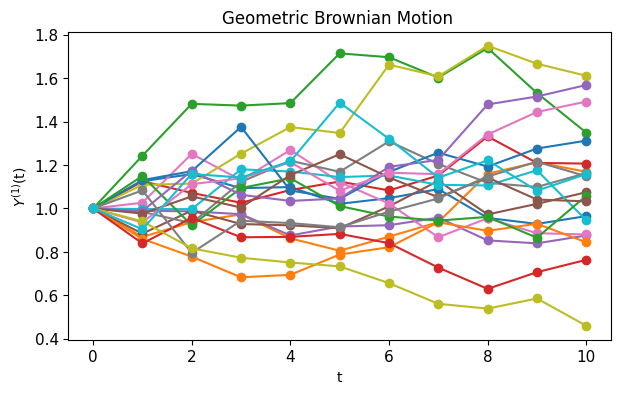

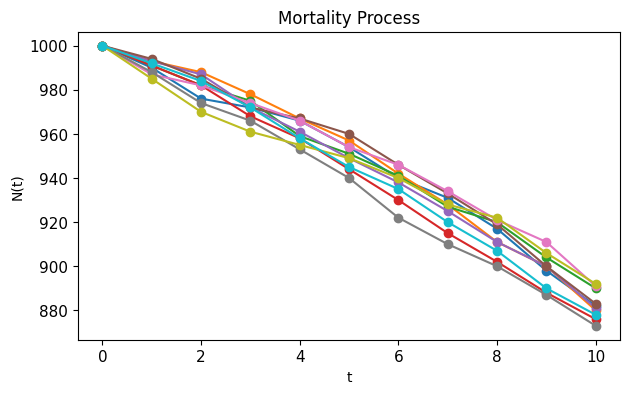

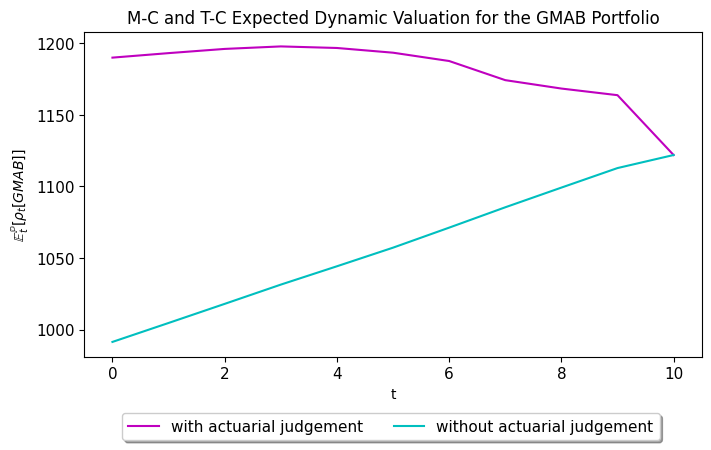

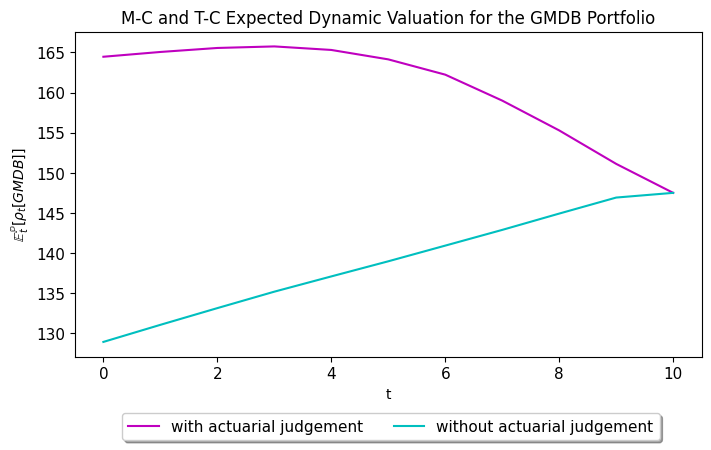

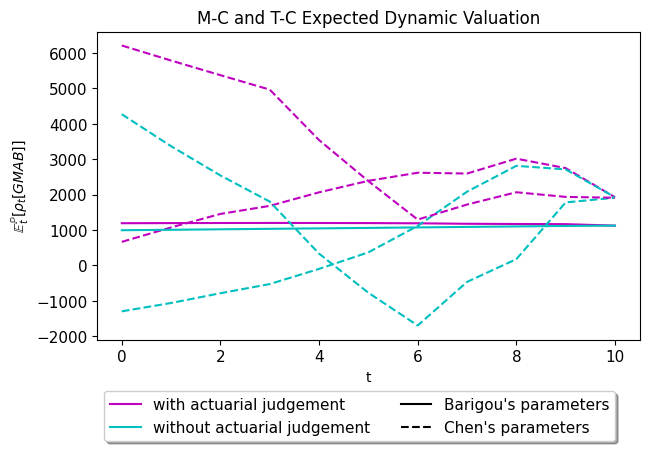

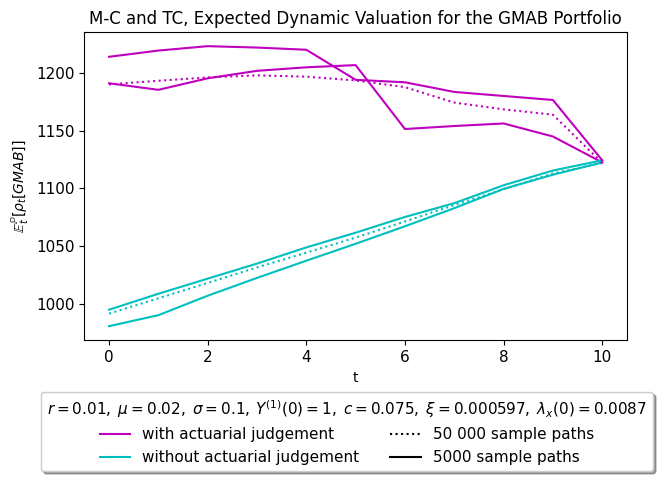

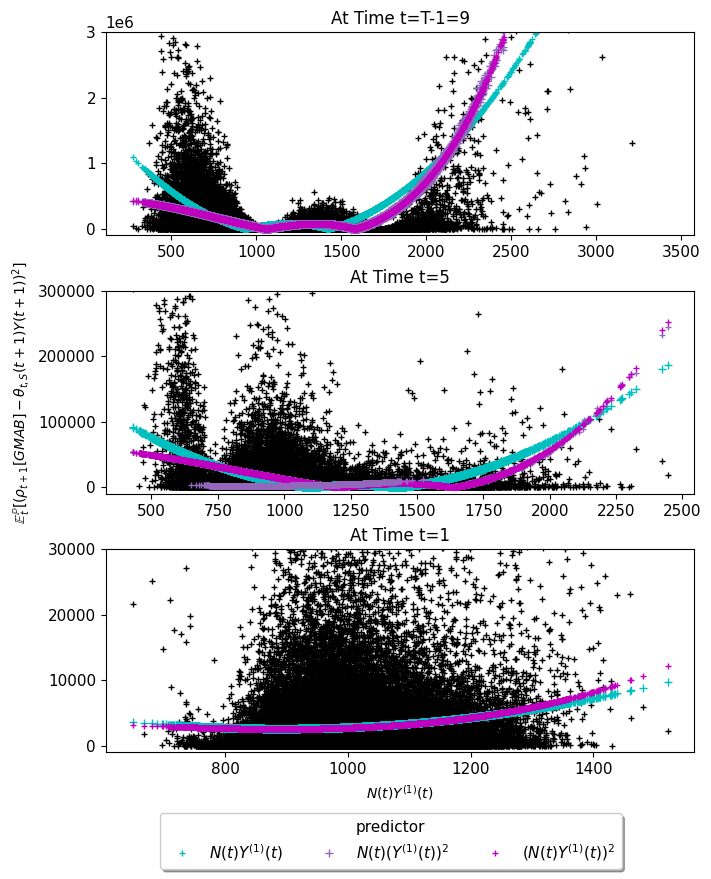

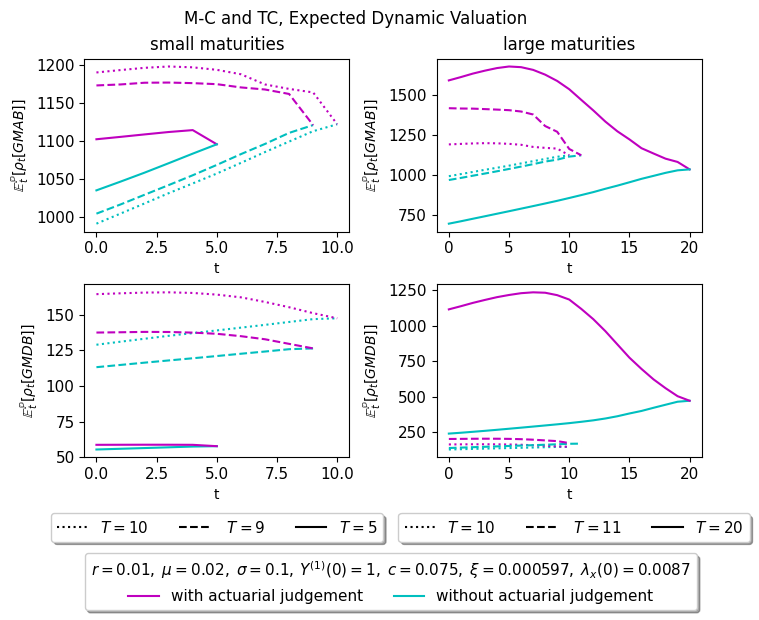

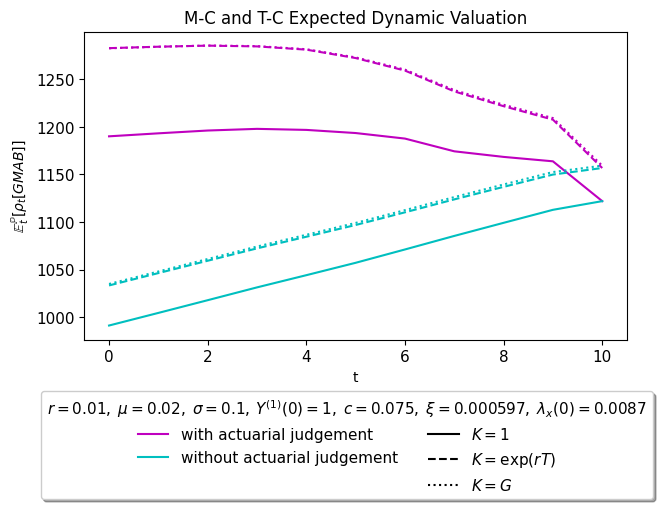

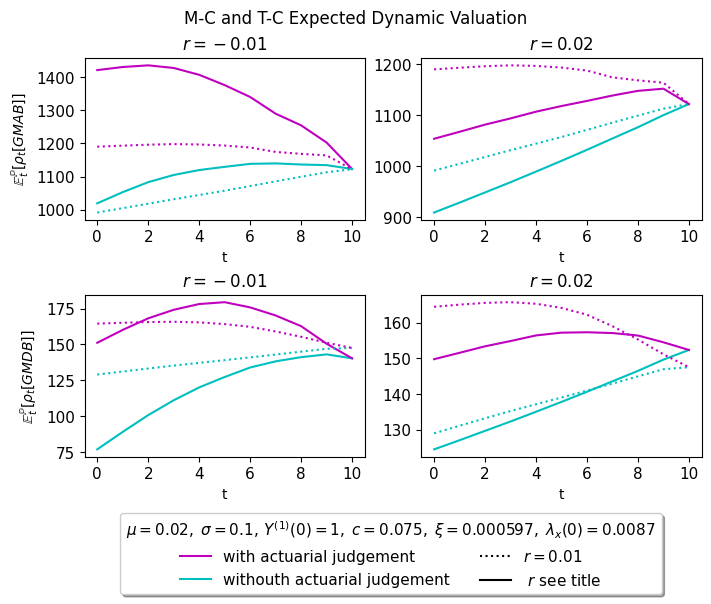

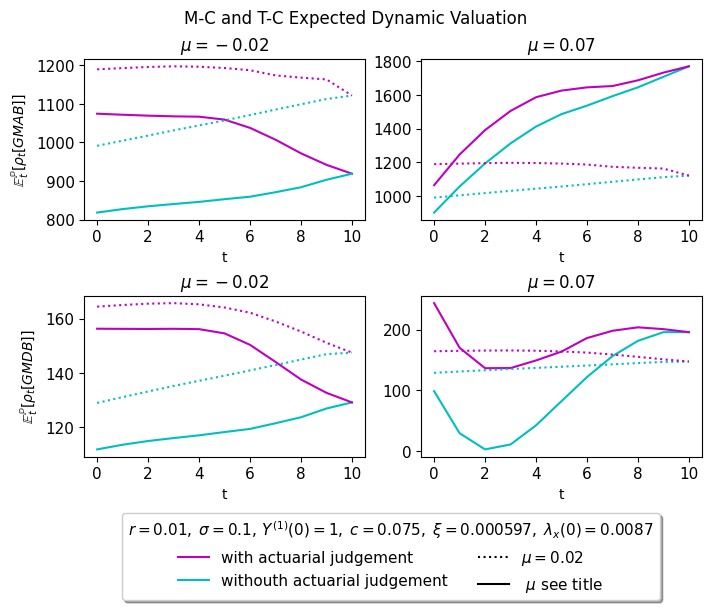

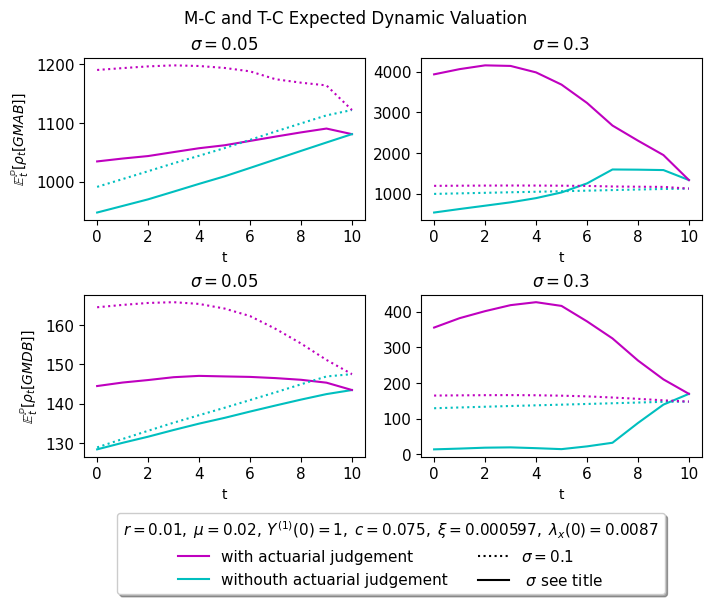

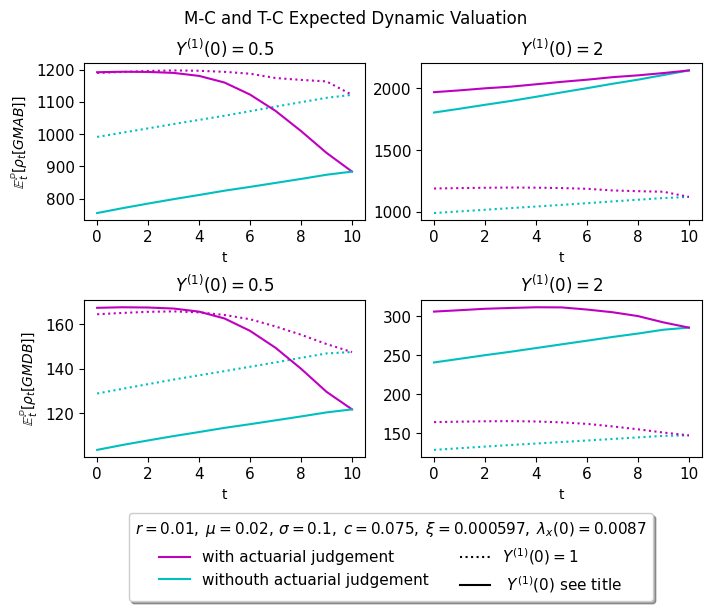

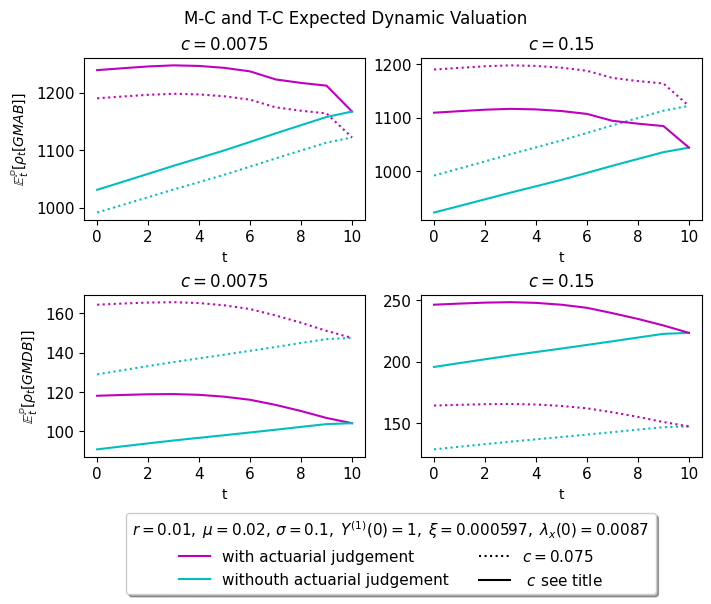

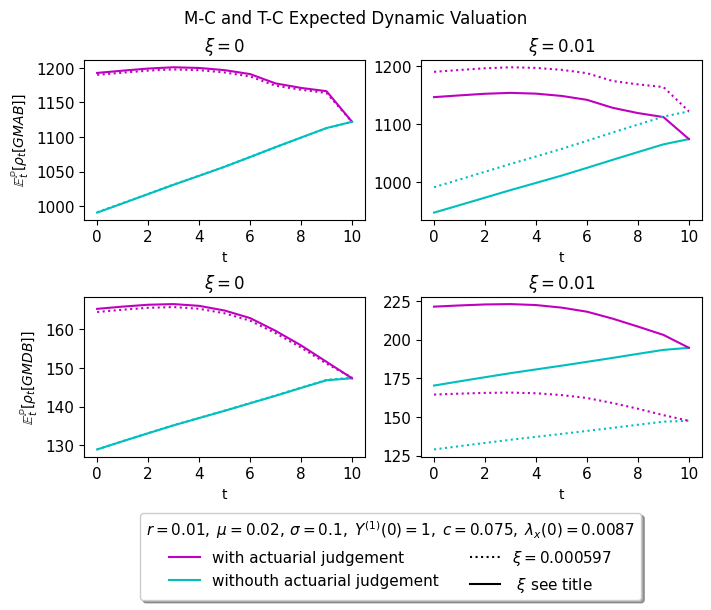

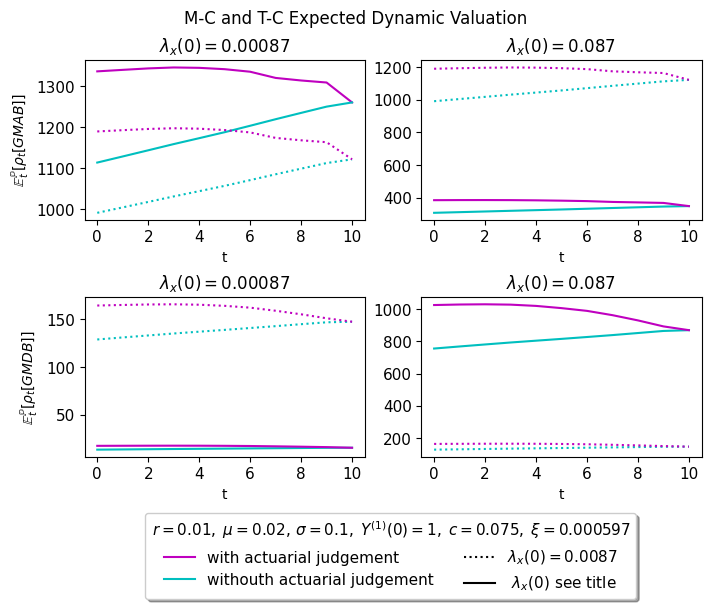

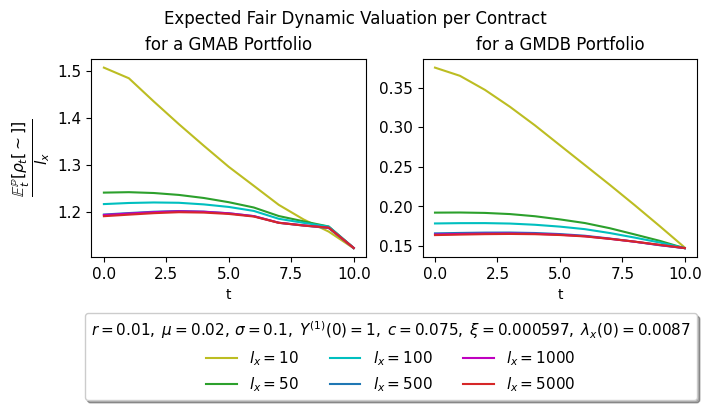

In [5]:
# Figures
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

## Y1 and N
t=range(T+1)
plt.figure(figsize=(7,4))
for n in range(20):
    plt.plot([Y1[s][n] for s in t],marker='o')
plt.title('Geometric Brownian Motion ')
plt.xlabel('t')
plt.ylabel('$Y^{(1)}$(t)')
plt.savefig('FIGURES/geomY1.png',bbox_inches="tight")

plt.figure(figsize=(7,4))
for n in range(10):
    plt.plot([N[s][n] for s in t],marker='o')
plt.title('Mortality Process')
plt.xlabel('t')
plt.ylabel('N(t)')
plt.savefig('FIGURES/mortN.png',bbox_inches="tight")


### Barigou's OG GMAB
t=range(11)
fig1=plt.figure(num='fig1',figsize=(7,4),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m',label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in range(11)],'c',label='without actuarial judgement')
plt.title('M-C and T-C Expected Dynamic Valuation for the GMAB Portfolio')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')
plt.figlegend(loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncol=2)
plt.savefig('FIGURES/GMAB_mvhb.png',bbox_inches="tight")


### Barigou's OG GMDB
t=range(11)
fig2=plt.figure(num='fig2',figsize=(7,4),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m',label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in range(11)],'c',label='without actuarial judgement')
plt.title('M-C and T-C Expected Dynamic Valuation for the GMDB Portfolio')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')
plt.figlegend(loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncol=2)
plt.savefig('FIGURES/GMDB_mvhb.png',bbox_inches="tight")

### Chen's parameters
fig3=plt.figure(num='fig3',figsize=(7,4))
ax = fig3.add_subplot()
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m',label='with actuarial judgement')
plt.plot([np.average(Chen_MC_TC_act_GMAB[s]) for s in t],'m--')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c',label='without actuarial judgement')
plt.plot([np.average(Chen_MC_TC_GMAB[s]) for s in t],'c--')
plt.plot([np.average(Chen_MC_TC_GMAB_2[s]) for s in t],'c--')
plt.plot([np.average(Chen_MC_TC_act_GMAB_2[s]) for s in t],'m--')
plt.title('M-C and T-C Expected Dynamic Valuation')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')
handles,labels=ax.get_legend_handles_labels()
Barigou = mlines.Line2D([], [], color='k')
Chen = mlines.Line2D([], [], color='k', linestyle='--')
handles=handles+[Barigou,Chen]
labels=labels+["Barigou's parameters", "Chen's parameters"]
plt.figlegend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=2)
plt.savefig('FIGURES/GMAB_mvhb_chen.png',bbox_inches="tight")

## Barigou's OG
fig4=plt.figure(num='fig4',figsize=(7,4)) #5,4 for 2 on line 7,5 for one on line

plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in range(11)],'c:',label='M-C and T-C valuation,50 000 sample paths')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:',label='TC, M-C and actuarial valuation, 50 000 sample paths')
plt.plot([np.average(rho_MC_TC_GMAB_5000[s]) for s in range(11)],'c',label='M-C and T-C valuation, 5000 sample paths')
plt.plot([np.average(rho_MC_TC_act_GMAB_5000[s]) for s in t],'m',label='TC, M-C and actuarial valuation, 5000 sample paths')
plt.plot([np.average(rho_MC_TC_GMAB_5000_2[s]) for s in range(11)],'c',label='M-C and T-C valuation, 5000 sample paths')
plt.plot([np.average(rho_MC_TC_act_GMAB_5000_2[s]) for s in t],'m',label='TC, M-C and actuarial valuation, 5000 sample paths')
plt.title('M-C and TC, Expected Dynamic Valuation for the GMAB Portfolio')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

OG = mlines.Line2D([], [], color='k', linestyle=':')
NEW = mlines.Line2D([], [], color='k')
empty= mlines.Line2D([], [], color='k', linestyle='none')
NoAct = mlines.Line2D([], [], color='c')
Act = mlines.Line2D([], [], color='m')
handles=[Act,NoAct,OG,NEW]
labels=['with actuarial judgement', 'without actuarial judgement', '50 000 sample paths', '5000 sample paths']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\; \sigma=0.1,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/GMAB_samplesize.png',bbox_inches="tight")

### Predictors

NY1=[[N[s][n]*Y1[s][n] for n in range(samples)] for s in t]
print('for $N(t)Y^{(1)}(t)$',sum(sum(abs(np.array(yx)-np.array(variancex))))) # 14 miljard?
print('for $N(t)(Y^{(1)}(t))^2$',sum(sum(abs(np.array(yx)-np.array(variancex2))))) # 13 miljard
print('for $(N(t)Y^{(1)}(t))^2$',sum(sum(abs(np.array(yx)-np.array(variancex3))))) # 13 miljard

fig = plt.figure(num='fig5',figsize=(7,8),layout="constrained")

ax1 = fig.add_subplot(311)
ax1.plot(NY1[T-1][0:50000],yx[T-1],'k', linestyle='none',marker='+',markersize=5)
ax1.plot(NY1[T-1][0:50000],variancex[T-1],'c',linestyle='none',marker='+', label='$N(t)Y^{(1)}(t)$',markersize=5)
ax1.plot(NY1[T-1][0:50000],variancex2[T-1],'tab:purple',linestyle='none',marker='+', label='$N(t)(Y^{(1)}(t))^2$',markersize=6)
ax1.plot(NY1[T-1][0:50000],variancex3[T-1],'m',linestyle='none',marker='+', label='$(N(t)Y^{(1)}(t))^2$',markersize=5)
ax1.set_title('At Time t=T-1=9')
ax1.set_ylim([-100000,3000000])

ax2 = fig.add_subplot(312)
ax2.plot(NY1[5][0:50000],yx[5],'k', linestyle='none',marker='+',markersize=5)
ax2.plot(NY1[5][0:50000],variancex[5],'c',linestyle='none',marker='+',markersize=6)
ax2.plot(NY1[5][0:50000],variancex2[5],'tab:purple',linestyle='none',marker='+',markersize=5)
ax2.plot(NY1[5][0:50000],variancex3[5],'m',linestyle='none',marker='+',markersize=5)
ax2.set_title('At Time t=5')
ax2.set_ylim([-10000,300000])

ax3 = fig.add_subplot(313)
a3=1
ax3.plot(NY1[a3][0:50000],yx[a3],'k', linestyle='none',marker='+',markersize=5)
ax3.plot(NY1[a3][0:50000],variancex[a3],'c',linestyle='none',marker='+',markersize=6)
ax2.plot(NY1[a3][0:50000],variancex2[a3],'tab:purple',linestyle='none',marker='+',markersize=5)
ax3.plot(NY1[a3][0:50000],variancex3[a3],'m',linestyle='none',marker='+',markersize=5)
ax3.set_title('At Time t='+str(a3))
ax3.set_ylim([-1000,30000])

handles, labels=ax1.get_legend_handles_labels()
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=3, title='predictor',title_fontsize=11)

ax3.set_xlabel(r'$N(t)Y^{(1)}(t)$')
ax2.set_ylabel(r'$\mathbb{E}^{\mathbb{P}}_t[(\rho_{t+1}[GMAB]-\theta_{t,S}(t+1) Y(t+1))^2]$')
plt.savefig('FIGURES/GMAB_LSMC_diff.png',bbox_inches="tight")

### Maturity
fig6=plt.figure(num='fig6',figsize=(7,5),layout="constrained")
plt.suptitle('M-C and TC, Expected Dynamic Valuation',fontsize=12)

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMAB_T9[s]) for s in range(10)],'c--')
plt.plot([np.average(rho_MC_TC_act_GMAB_T9[s]) for s in range(10)],'m--')
plt.plot([np.average( rho_MC_TC_act_GMAB_T5[s]) for s in range(6)],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_T5[s]) for s in range(6)],'c',label='withouth actuarial judgement')
plt.title('small maturities')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMDB_T9[s]) for s in range(10)],'c--')
plt.plot([np.average(rho_MC_TC_act_GMDB_T9[s]) for s in range(10)],'m--')
plt.plot([np.average(rho_MC_TC_GMDB_T5[s]) for s in range(6)],'c')
plt.plot([np.average( rho_MC_TC_act_GMDB_T5[s]) for s in range(6)],'m')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax3 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMAB_T11[s]) for s in range(12)],'c--')
plt.plot([np.average(rho_MC_TC_act_GMAB_T11[s]) for s in range(12)],'m--')
plt.plot([np.average( rho_MC_TC_act_GMAB_T20[s]) for s in range(21)],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_T20[s]) for s in range(21)],'c',label='withouth actuarial judgement')
plt.title('large maturities')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMDB_T11[s]) for s in range(12)],'c--')
plt.plot([np.average(rho_MC_TC_act_GMDB_T11[s]) for s in range(11)],'m--')
plt.plot([np.average(rho_MC_TC_GMDB_T20[s]) for s in range(21)],'c')
plt.plot([np.average( rho_MC_TC_act_GMDB_T20[s]) for s in range(21)],'m')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

NoAct = mlines.Line2D([], [], color='c')
Act = mlines.Line2D([], [], color='m')
handles=[Act,NoAct]
labels=['with actuarial judgement', 'without actuarial judgement']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.08), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\; \sigma=0.1,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)


OG = mlines.Line2D([], [], color='k', linestyle=':')
Changed1 = mlines.Line2D([], [], color='k', linestyle='--')
Changed = mlines.Line2D([], [], color='k')
handles=[OG,Changed1,Changed]
labels=[r'$T=10$',r' $T=9$',r'$T=5$']
l1=plt.figlegend(handles, labels, loc='upper right', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncol=3)
handles=[OG,Changed1,Changed]
labels=[r'$T=10$',r' $T=11$',r'$T=20$']
l1=plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncol=3)
plt.savefig('FIGURES/mvhb_Maturities.png',bbox_inches='tight')


### Guaranteed Benefit
fig=plt.figure(num='fig10',figsize=(7,4))
ax = fig.add_subplot()
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m',label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c',label='without actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_Kexp[s]) for s in t],'c--')
plt.plot([np.average(rho_MC_TC_act_GMAB_Kexp[s]) for s in t],'m--')
plt.plot([np.average(rho_MC_TC_GMAB_KG[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB_KG[s]) for s in t],'m:')
plt.title('M-C and T-C Expected Dynamic Valuation')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')
handles,labels=ax.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[empty, full,dash,dotted]
labels=labels+["","$K=1$", "$K=\exp(rT)$","$K=G$"]
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\; \sigma=0.1,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_K.png',bbox_inches='tight')

## Financial 
### r

fig=plt.figure(num='fig11',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_act_GMAB_rneg[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_rneg[s]) for s in t],'c',label='withouth actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$r=-0.01$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB_r02[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_r02[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$r=0.02$')
plt.xlabel('t')


ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_rneg[s]) for s in t],'c',label='TC,MC')
plt.plot([np.average(rho_MC_TC_act_GMDB_rneg[s]) for s in t],'m',label='TC,MC,actuarial')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$r=-0.01$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_r02[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_r02[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$r=0.02$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$r=0.01$',r' $r$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$\mu=0.02,\; \sigma=0.1,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_r.png',bbox_inches='tight')


### mu

fig=plt.figure(num='fig12',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_act_GMAB_muneg[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_muneg[s]) for s in t],'c',label='withouth actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\mu=-0.02$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB_mu07[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_mu07[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\mu=0.07$')
plt.xlabel('t')


ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_muneg[s]) for s in t],'c',label='TC,MC')
plt.plot([np.average(rho_MC_TC_act_GMDB_muneg[s]) for s in t],'m',label='TC,MC,actuarial')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\mu=-0.02$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_mu07[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_mu07[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\mu=0.07$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$\mu=0.02$',r' $\mu$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \sigma=0.1,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_mu.png',bbox_inches='tight')

### sigma

fig=plt.figure(num='fig13',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_act_GMAB_sig05[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_sig05[s]) for s in t],'c',label='withouth actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\sigma=0.05$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB_sig3[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_sig3[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\sigma=0.3$')
plt.xlabel('t')


ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_sig05[s]) for s in t],'c',label='TC,MC')
plt.plot([np.average(rho_MC_TC_act_GMDB_sig05[s]) for s in t],'m',label='TC,MC,actuarial')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\sigma=0.05$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_sig3[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_sig3[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\sigma=0.3$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$\sigma=0.1$',r' $\sigma$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\, Y^{(1)}(0)=1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_sigma.png',bbox_inches='tight')


### Y1(0)

fig=plt.figure(num='fig14',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_act_GMAB_Y1_0_05[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_Y1_0_05[s]) for s in t],'c', label='withouth actuarial judgement')
plt.title(r'$Y^{(1)}(0)=0.5$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMAB_Y1_0_2[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_Y1_0_2[s]) for s in t],'m')
plt.title(r'$Y^{(1)}(0)=2$')
plt.xlabel('t')

ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_act_GMDB_Y1_0_05[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMDB_Y1_0_05[s]) for s in t],'c', label='withouth actuarial judgement')
plt.title(r'$Y^{(1)}(0)=0.5$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMDB_Y1_0_2[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_Y1_0_2[s]) for s in t],'m')
plt.title(r'$Y^{(1)}(0)=2$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$Y^{(1)}(0)=1$',r' $Y^{(1)}(0)$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\, \sigma=0.1, \; c=0.075,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_Y1_0.png',bbox_inches='tight')


# Actuarial
# c
fig=plt.figure(num='figA1',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')

ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_act_GMAB_c0075[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_c0075[s]) for s in t],'c', label='withouth actuarial judgement')
plt.title(r'$c=0.0075$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMAB_c015[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_c015[s]) for s in t],'m')
plt.title(r'$c=0.15$')
plt.xlabel('t')

ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_act_GMDB_c0075[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMDB_c0075[s]) for s in t],'c', label='withouth actuarial judgement')
plt.title(r'$c=0.0075$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.plot([np.average(rho_MC_TC_GMDB_c015[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_c015[s]) for s in t],'m')
plt.title(r'$c=0.15$')
plt.xlabel('t')
handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$c=0.075$',r' $c$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\, \sigma=0.1, \; Y^{(1)}(0)=1,\; \xi=0.000597,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_c.png',bbox_inches='tight')

fig=plt.figure(num='figA2',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')


ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_act_GMAB_xi_small[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_xi_small[s]) for s in t],'c',label='withouth actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\xi=0$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')

ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB_xi_large[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_xi_large[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title(r'$\xi=0.01$')
plt.xlabel('t')


ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_xi_small[s]) for s in t],'c',label='TC,MC')
plt.plot([np.average(rho_MC_TC_act_GMDB_xi_small[s]) for s in t],'m',label='TC,MC,actuarial')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\xi=0$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')

ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_xi_large[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_xi_large[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title(r'$\xi=0.01$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$\xi=0.000597$',r' $\xi$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\, \sigma=0.1, \; Y^{(1)}(0)=1,\; c=0.075,\; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_xi.png',bbox_inches='tight')


fig=plt.figure(num='figA3',figsize=(7,5),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('M-C and T-C Expected Dynamic Valuation')


ax1 = plt.subplot2grid((2,2),(0,0), colspan=1)
plt.plot([np.average(rho_MC_TC_act_GMAB_lam0_00087[s]) for s in t],'m', label='with actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB_lam0_00087[s]) for s in t],'c', label='withouth actuarial judgement')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title('$\lambda_x(0)=0.00087$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMAB]]$')
ax2 = plt.subplot2grid((2,2),(0,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMAB_lam0_087[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMAB_lam0_087[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMAB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMAB[s]) for s in t],'m:')
plt.title('$\lambda_x(0)=0.087$')
plt.xlabel('t')

ax3 = plt.subplot2grid((2,2),(1,0), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_lam0_00087[s]) for s in t],'c',label='TC,MC')
plt.plot([np.average(rho_MC_TC_act_GMDB_lam0_00087[s]) for s in t],'m',label='TC,MC,actuarial')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title('$\lambda_x(0)=0.00087$')
plt.xlabel('t')
plt.ylabel(r'$\mathbb{E}^\mathbb{P}_t[\rho_t[GMDB]]$')
ax4 = plt.subplot2grid((2,2),(1,1), colspan=1)
plt.plot([np.average(rho_MC_TC_GMDB_lam0_087[s]) for s in t],'c')
plt.plot([np.average(rho_MC_TC_act_GMDB_lam0_087[s]) for s in t],'m')
plt.plot([np.average(rho_MC_TC_GMDB[s]) for s in t],'c:')
plt.plot([np.average(rho_MC_TC_act_GMDB[s]) for s in t],'m:')
plt.title('$\lambda_x(0)=0.087$')
plt.xlabel('t')


handles, labels = ax1.get_legend_handles_labels()
full = mlines.Line2D([], [], color='k')
dash = mlines.Line2D([], [], color='k', linestyle='--')
dotted = mlines.Line2D([], [], color='k', linestyle=':')
empty= mlines.Line2D([], [], color='k', linestyle='none')
handles=handles+[dotted,full]
labels=labels+[r'$\lambda_x(0)=0.0087$',r' $\lambda_x(0)$ see title']
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=2, title= r'$r=0.01,\; \mu=0.02,\, \sigma=0.1, \; Y^{(1)}(0)=1,\; c=0.075,\; \xi=0.000597$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_lam0.png',bbox_inches='tight')

### portfolio sizes

fig1=plt.figure(num='figB',figsize=(7,3),layout="constrained") #5,4 for 2 on line 7,5 for one on line
plt.suptitle('Expected Fair Dynamic Valuation per Contract',fontsize=12)

ax1 = plt.subplot2grid((1,2),(0,0), colspan=1)
plt.title('for a GMAB Portfolio',fontsize=12)
plt.plot([np.average(rho_MC_TC_act_GMAB_lx10[s]) for s in t], 'tab:olive', label=r'$l_x=10$')
plt.plot([np.average(rho_MC_TC_act_GMAB_lx50[s]) for s in t], 'tab:green',label=r'$l_x=50$')
plt.plot([np.average(rho_MC_TC_act_GMAB_lx100[s]) for s in t], 'c', label=r'$l_x=100$')
plt.plot([np.average(rho_MC_TC_act_GMAB_lx500[s]) for s in t], 'tab:blue',label=r'$l_x=500$')
plt.plot([np.average(rho_MC_TC_act_GMAB_lx1000[s]) for s in t],'m', label=r'$l_x=1000$')
plt.plot([np.average(rho_MC_TC_act_GMAB_lx5000[s]) for s in t], 'tab:red', label=r'$l_x=5000$')
plt.xlabel('t')
plt.ylabel(r'$\frac{\mathbb{E}^\mathbb{P}_t[\rho_t[\sim]]}{l_x}$',fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1), colspan=1)
plt.title('for a GMDB Portfolio',fontsize=12)
plt.plot([np.average(rho_MC_TC_act_GMDB_lx10[s]) for s in t],'tab:olive', label=r'$l_x=10$')
plt.plot([np.average(rho_MC_TC_act_GMDB_lx50[s]) for s in t],'tab:green', label=r'$l_x=50$')
plt.plot([np.average(rho_MC_TC_act_GMDB_lx100[s]) for s in t], 'c', label=r'$l_x=100$')
plt.plot([np.average(rho_MC_TC_act_GMDB_lx500[s]) for s in t], 'tab:blue', label=r'$l_x=500$')
plt.plot([np.average(rho_MC_TC_act_GMDB_lx1000[s]) for s in t],'m', label=r'$l_x=1000$')
plt.plot([np.average(rho_MC_TC_act_GMDB_lx5000[s]) for s in t], 'tab:red', label=r'$l_x=5000$')
plt.xlabel('t')

handles, labels = ax1.get_legend_handles_labels()
OG = mlines.Line2D([], [], color='k', linestyle='none')
l1=plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), fancybox=True, shadow=True, ncols=3,title= r'$r=0.01,\; \mu=0.02,\, \sigma=0.1, \; Y^{(1)}(0)=1,\; c=0.075,\; \xi=0.000597, \; \lambda_x(0)=0.0087$',title_fontsize=11)
plt.savefig('FIGURES/mvhb_lx.png',bbox_inches='tight')